# Creación de modelos predictivos

In [62]:
# DEfinir las características (X) y la variable objetivo (y)

# Se excluyen las columnas irrelevantes o que darían las respuestas correctas al modelo
X = df_scaled.drop(columns=['Churn', 'ContractDuration', 'DurationSegment'])  

# Variable objetivo
y = df_scaled['Churn']  

# División de los datos en entrenamiento (80%) y prueba (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# REvisar dimensiones de los conjuntos
print(f"Dimensiones del conjunto de entrenamiento: {X_train.shape}")
print(f"Dimensiones del conjunto de prueba: {X_test.shape}")

Dimensiones del conjunto de entrenamiento: (3865, 35)
Dimensiones del conjunto de prueba: (967, 35)


In [63]:
# Validar cambios en las columnas eliminadas y agregadas
df_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4832 entries, 0 to 4831
Data columns (total 38 columns):
 #   Column                                   Non-Null Count  Dtype   
---  ------                                   --------------  -----   
 0   MonthlyCharges                           4832 non-null   float64 
 1   TotalCharges                             4832 non-null   float64 
 2   ContractDuration                         4832 non-null   float64 
 3   DurationSegment                          4832 non-null   category
 4   Type_Month-to-month                      4832 non-null   bool    
 5   Type_One year                            4832 non-null   bool    
 6   Type_Two year                            4832 non-null   bool    
 7   PaperlessBilling_No                      4832 non-null   bool    
 8   PaperlessBilling_Yes                     4832 non-null   bool    
 9   PaymentMethod_Bank transfer (automatic)  4832 non-null   bool    
 10  PaymentMethod_Credit card (automatic

## Bosque aleatorio

In [64]:
# Definimos el modelo base
rf_model = RandomForestClassifier(random_state=42)

# Especificamos los hiperparámetros a probar
param_grid = {
    'n_estimators': [50, 100, 150],  # Número de árboles
    'max_depth': [None, 10, 20, 30],  # Profundidad máxima de los árboles
    'min_samples_split': [2, 5, 10],  # Número mínimo de muestras para dividir un nodo
    'min_samples_leaf': [1, 2, 4],  # Número mínimo de muestras en un nodo hoja
}

# Configuramos Grid Search enfocado en optimizar únicamente la métrica Recall
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid,
    scoring='recall',  # Se prioriza minimizar los falsos negativos con métrica Recall
    cv=5,  # Validación cruzada
    verbose=2,
    n_jobs=-1)  # Utilizamos todos los núcleos disponibles

# Ejecutamos la búsqueda
grid_search.fit(X_train, y_train)

# Mostramos los mejores parámetros encontrados
print("Mejores parámetros:", grid_search.best_params_)
print("Mejor recall obtenido:", grid_search.best_score_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Mejores parámetros: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 150}
Mejor recall obtenido: 0.8763420779605751


In [65]:
# Definimos el modelo base
rf_model = RandomForestClassifier(random_state=42)

# Especificamos los hiperparámetros a probar
param_grid = {
    'n_estimators': [50, 100, 150],  # Número de árboles
    'max_depth': [None, 10, 20, 30],  # Profundidad máxima de los árboles
    'min_samples_split': [2, 5, 10],  # Número mínimo de muestras para dividir un nodo
    'min_samples_leaf': [1, 2, 4],  # Número mínimo de muestras en un nodo hoja
}

# Configuramos Grid Search con múltiples métricas dando prioridad a AUC-ROC
grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    scoring={'roc_auc': 'roc_auc', 'accuracy': 'accuracy'},  # Optimización basada en AUC-ROC y exactitud
    refit='roc_auc',  # Modelo final se ajustará con la métrica principal
    cv=5,  # Validación cruzada
    verbose=2,
    n_jobs=-1)

# Ejecutamos la búsqueda
grid_search.fit(X_train, y_train)

# Resultados
print("Mejores parámetros encontrados:")
print(grid_search.best_params_)

print("\nMejor AUC-ROC obtenido durante la optimización:")
print(grid_search.best_score_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Mejores parámetros encontrados:
{'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 150}

Mejor AUC-ROC obtenido durante la optimización:
0.821901321576328


In [66]:
# Crear y entrenar el modelo optimizado seleccionando mejores hiperparámetros
optimized_rf_model = RandomForestClassifier(
    random_state=42, 
    max_depth=10, 
    min_samples_leaf=4, 
    min_samples_split=10, 
    n_estimators=150, 
    class_weight='balanced'
)
optimized_rf_model.fit(X_train, y_train)

# Realizamos predicciones con el modelo optimizado
y_pred_optimized = optimized_rf_model.predict(X_test)
y_prob_optimized = optimized_rf_model.predict_proba(X_test)[:, 1]

# Métricas principales
auc_roc_optimized = roc_auc_score(y_test, y_prob_optimized)
accuracy_optimized = accuracy_score(y_test, y_pred_optimized)

print(f"AUC-ROC del modelo optimizado: {auc_roc_optimized:.3f}")
print(f"Exactitud del modelo optimizado: {accuracy_optimized:.3f}")
print("\nMatriz de Confusión:")
print(confusion_matrix(y_test, y_pred_optimized))
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred_optimized))

AUC-ROC del modelo optimizado: 0.799
Exactitud del modelo optimizado: 0.736

Matriz de Confusión:
[[224  93]
 [162 488]]

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.58      0.71      0.64       317
           1       0.84      0.75      0.79       650

    accuracy                           0.74       967
   macro avg       0.71      0.73      0.72       967
weighted avg       0.75      0.74      0.74       967



In [67]:
# Agregar validación cruzada usando KFold

# Definimos el modelo base
rf_model = RandomForestClassifier(
    random_state=42,
    max_depth=10,
    min_samples_leaf=4,
    min_samples_split=2,
    n_estimators=150,
    class_weight='balanced'
)

# Configuramos K-Fold Cross-Validation (5 folds)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Usamos cross_validate para calcular múltiples métricas, incluyendo AUC-ROC
scoring = {
    'precision': make_scorer(precision_score, average='weighted'), 
    'recall': make_scorer(recall_score, average='weighted'),
    'f1': make_scorer(f1_score, average='weighted'),
    'roc_auc': make_scorer(roc_auc_score, response_method='predict_proba')  # AUC-ROC agregado
}

# Validación cruzada
cv_results = cross_validate(
    rf_model,
    X_train,
    y_train,
    cv=kf,
    scoring=scoring,
    return_train_score=True
)

# Imprimir resultados
print("Precisión promedio:", round(np.mean(cv_results['test_precision']), 3))
print("Recall promedio:", round(np.mean(cv_results['test_recall']), 3))
print("F1-Score promedio:", round(np.mean(cv_results['test_f1']), 3))
print("AUC-ROC promedio:", round(np.mean(cv_results['test_roc_auc']), 3))

Precisión promedio: 0.765
Recall promedio: 0.746
F1-Score promedio: 0.752
AUC-ROC promedio: 0.816


## XgBoost

Matriz de Confusión:
[[173 144]
 [142 508]]

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.55      0.55      0.55       317
           1       0.78      0.78      0.78       650

    accuracy                           0.70       967
   macro avg       0.66      0.66      0.66       967
weighted avg       0.70      0.70      0.70       967

AUC-ROC del modelo base: 0.734
Exactitud del modelo base: 0.704


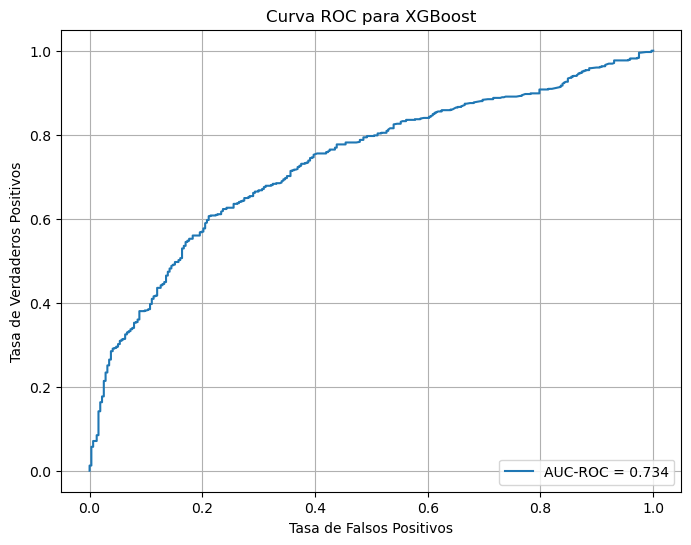

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Mejores parámetros para XGBoost:
{'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.5}

Mejor AUC-ROC obtenido durante la optimización:
0.8020217737333877


C:\Users\ricar\anaconda3\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [68]:
# Conversión de columnas booleanas a valores numéricos (0 y 1)
X_train = X_train.astype(int)
X_test = X_test.astype(int)

# Entrenamos un modelo base de XGBoost sin el parámetro obsoleto `use_label_encoder` para evitar advertencias
xgb_model = XGBClassifier(
    random_state=42,
    eval_metric='logloss'  # Configuración explícita para evitar advertencias
)
xgb_model.fit(X_train, y_train)

# Realizamos predicciones en el conjunto de prueba
y_pred_xgb = xgb_model.predict(X_test)
y_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]  # Probabilidades para la clase positiva

# Evaluamos el rendimiento del modelo
print("Matriz de Confusión:")
print(confusion_matrix(y_test, y_pred_xgb))

print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred_xgb))

# Métricas principales
auc_roc_xgb = roc_auc_score(y_test, y_prob_xgb)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)

print(f"AUC-ROC del modelo base: {auc_roc_xgb:.3f}")
print(f"Exactitud del modelo base: {accuracy_xgb:.3f}")

# Graficamos la Curva ROC
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test, y_prob_xgb)
plt.figure(figsize=(8, 6))
plt.plot(fpr_xgb, tpr_xgb, label=f"AUC-ROC = {auc_roc_xgb:.3f}")
plt.xlabel("Tasa de Falsos Positivos")
plt.ylabel("Tasa de Verdaderos Positivos")
plt.title("Curva ROC para XGBoost")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# Configuramos Grid Search para optimizar hiperparámetros
param_grid_xgb = {
    'n_estimators': [50, 100, 150],  # Número de estimadores
    'max_depth': [3, 6, 10],  # Profundidad máxima de los árboles
    'learning_rate': [0.01, 0.1, 0.2],  # Tasa de aprendizaje
    'subsample': [0.5, 0.7, 1.0],  # Fracción de muestras para cada árbol
    'colsample_bytree': [0.6, 0.8, 1.0]  # Fracción de características usadas por árbol
}

# Modelo base sin el parámetro `use_label_encoder`
xgb_model_base = XGBClassifier(
    random_state=42, 
    eval_metric='logloss'  # Configuración explícita para evitar advertencias
)

grid_search_xgb = GridSearchCV(
    estimator=xgb_model_base,
    param_grid=param_grid_xgb,
    scoring='roc_auc',  # Métrica principal: AUC-ROC
    cv=5,  # Validación cruzada
    verbose=2,
    n_jobs=-1  
)

# Ejecutamos la búsqueda
grid_search_xgb.fit(X_train, y_train)

# Resultados
print("Mejores parámetros para XGBoost:")
print(grid_search_xgb.best_params_)
print("\nMejor AUC-ROC obtenido durante la optimización:")
print(grid_search_xgb.best_score_)

In [69]:
# Especificamos los hiperparámetros a probar
param_grid_xgb = {
    'n_estimators': [50, 100, 150],  # Número de estimadores
    'max_depth': [3, 6, 10],  # Profundidad máxima de los árboles
    'learning_rate': [0.01, 0.1, 0.2],  # Tasa de aprendizaje
    'subsample': [0.5, 0.7, 1.0],  # Fracción de muestras para cada árbol
    'colsample_bytree': [0.6, 0.8, 1.0]  # Fracción de características usadas por árbol
}

# Modelo base sin el parámetro `use_label_encoder`
xgb_model_base = XGBClassifier(
    random_state=42, 
    eval_metric='logloss'  # Configuración explícita para evitar advertencias
)

# Configuramos Grid Search
grid_search_xgb = GridSearchCV(
    estimator=xgb_model_base,
    param_grid=param_grid_xgb,
    scoring='roc_auc',  # Métrica principal: AUC-ROC
    cv=5,  # Validación cruzada
    verbose=2,
    n_jobs=-1  # Utilizamos todos los núcleos disponibles
)

# Ejecutamos la búsqueda
grid_search_xgb.fit(X_train, y_train)

# Resultados
print("Mejores parámetros para XGBoost:")
print(grid_search_xgb.best_params_)
print("\nMejor AUC-ROC obtenido durante la optimización:")
print(grid_search_xgb.best_score_)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Mejores parámetros para XGBoost:
{'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.5}

Mejor AUC-ROC obtenido durante la optimización:
0.8020217737333877


C:\Users\ricar\anaconda3\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Matriz de Confusión:
[[178 139]
 [122 528]]

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.59      0.56      0.58       317
           1       0.79      0.81      0.80       650

    accuracy                           0.73       967
   macro avg       0.69      0.69      0.69       967
weighted avg       0.73      0.73      0.73       967

AUC-ROC del modelo optimizado: 0.780
Exactitud del modelo optimizado: 0.730


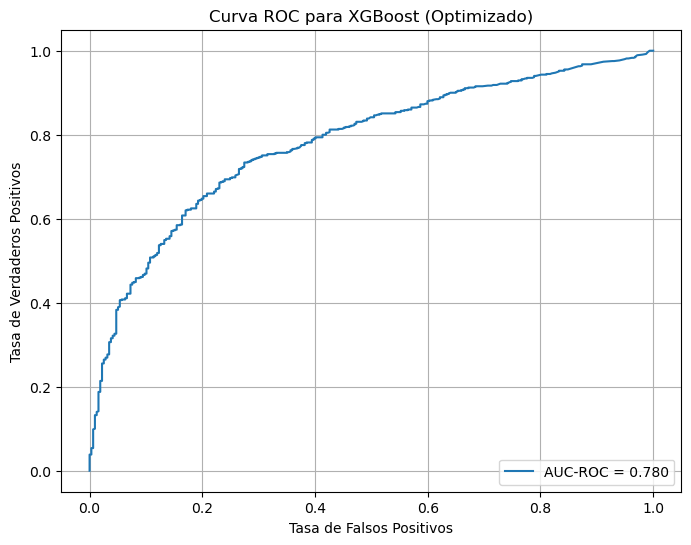

In [70]:
# Aplicamos los parámetros optimizados al modelo
optimized_xgb_model = XGBClassifier(
    random_state=42,
    eval_metric='logloss',  # Configuración explícita para evitar advertencias
    n_estimators=grid_search_xgb.best_params_['n_estimators'],
    max_depth=grid_search_xgb.best_params_['max_depth'],
    learning_rate=grid_search_xgb.best_params_['learning_rate'],
    subsample=grid_search_xgb.best_params_['subsample'],
    colsample_bytree=grid_search_xgb.best_params_['colsample_bytree']
)

# Entrenamos el modelo optimizado
optimized_xgb_model.fit(X_train, y_train)

# Realizamos predicciones en el conjunto de prueba
y_pred_optimized_xgb = optimized_xgb_model.predict(X_test)
y_prob_optimized_xgb = optimized_xgb_model.predict_proba(X_test)[:, 1]  # Probabilidades para la clase positiva

# Evaluamos el rendimiento del modelo optimizado
print("Matriz de Confusión:")
print(confusion_matrix(y_test, y_pred_optimized_xgb))

print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred_optimized_xgb))

# Métricas principales
auc_roc_optimized_xgb = roc_auc_score(y_test, y_prob_optimized_xgb)
accuracy_optimized_xgb = accuracy_score(y_test, y_pred_optimized_xgb)

print(f"AUC-ROC del modelo optimizado: {auc_roc_optimized_xgb:.3f}")
print(f"Exactitud del modelo optimizado: {accuracy_optimized_xgb:.3f}")

# Graficamos la Curva ROC
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test, y_prob_optimized_xgb)
plt.figure(figsize=(8, 6))
plt.plot(fpr_xgb, tpr_xgb, label=f"AUC-ROC = {auc_roc_optimized_xgb:.3f}")
plt.xlabel("Tasa de Falsos Positivos")
plt.ylabel("Tasa de Verdaderos Positivos")
plt.title("Curva ROC para XGBoost (Optimizado)")
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [71]:
# Definimos el modelo XGBoost optimizado
xgb_model = XGBClassifier(
    random_state=42,
    eval_metric='logloss',  # Configuración explícita para evitar advertencias
    n_estimators=50, 
    max_depth=3, 
    learning_rate=0.1, 
    subsample=0.5, 
    colsample_bytree=0.8
)

# Configuración del K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Definimos las métricas personalizadas
scoring = {
    'precision': make_scorer(precision_score, average='weighted'), 
    'recall': make_scorer(recall_score, average='weighted'),
    'f1': make_scorer(f1_score, average='weighted'),
    'roc_auc': make_scorer(roc_auc_score, response_method='predict_proba')  # Usamos response_method para evitar la advertencia
}

# Realizamos la validación cruzada
cv_results = cross_validate(
    xgb_model, 
    X_train, 
    y_train, 
    cv=kf, 
    scoring=scoring, 
    return_train_score=True
)

# Mostramos los resultados promedio de cada métrica
print("Precisión promedio:", round(np.mean(cv_results['test_precision']), 3))
print("Recall promedio:", round(np.mean(cv_results['test_recall']), 3))
print("F1-Score promedio:", round(np.mean(cv_results['test_f1']), 3))
print("AUC-ROC promedio:", round(np.mean(cv_results['test_roc_auc']), 3))

Precisión promedio: 0.735
Recall promedio: 0.742
F1-Score promedio: 0.737
AUC-ROC promedio: 0.798


## CatBoost

Matriz de Confusión:
[[173 144]
 [135 515]]

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.56      0.55      0.55       317
           1       0.78      0.79      0.79       650

    accuracy                           0.71       967
   macro avg       0.67      0.67      0.67       967
weighted avg       0.71      0.71      0.71       967

AUC-ROC del modelo base: 0.741
Exactitud del modelo base: 0.711


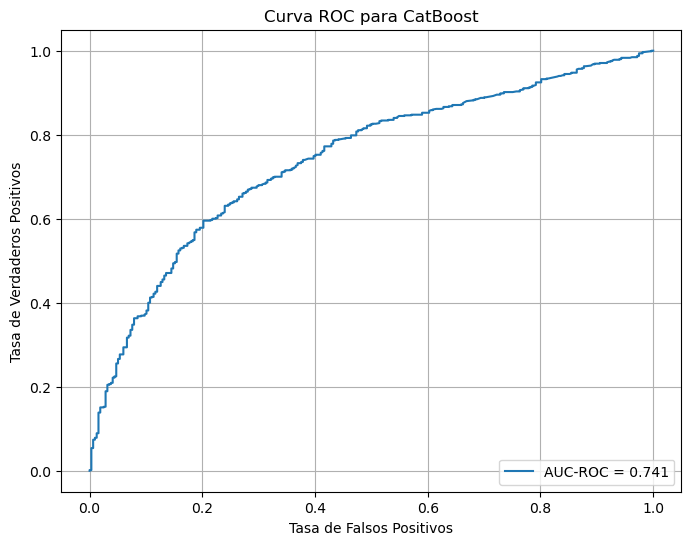

In [72]:
# Entrenamos un modelo base de CatBoost
catboost_model = CatBoostClassifier(
    random_state=42,
    iterations=500,  # Número de iteraciones
    learning_rate=0.1,  # Tasa de aprendizaje
    depth=6,  # Profundidad de los árboles
    eval_metric='AUC',  # Métrica principal AUC
    verbose=0
)
catboost_model.fit(X_train, y_train)

# Realizamos predicciones en el conjunto de prueba
y_pred_catboost = catboost_model.predict(X_test)
y_prob_catboost = catboost_model.predict_proba(X_test)[:, 1]  # Probabilidades para la clase positiva

# Evaluamos el rendimiento del modelo
print("Matriz de Confusión:")
print(confusion_matrix(y_test, y_pred_catboost))

print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred_catboost))

# Métricas principales
auc_roc_catboost = roc_auc_score(y_test, y_prob_catboost)
accuracy_catboost = accuracy_score(y_test, y_pred_catboost)

print(f"AUC-ROC del modelo base: {auc_roc_catboost:.3f}")
print(f"Exactitud del modelo base: {accuracy_catboost:.3f}")

# Graficamos la Curva ROC
fpr_catboost, tpr_catboost, thresholds_catboost = roc_curve(y_test, y_prob_catboost)
plt.figure(figsize=(8, 6))
plt.plot(fpr_catboost, tpr_catboost, label=f"AUC-ROC = {auc_roc_catboost:.3f}")
plt.xlabel("Tasa de Falsos Positivos")
plt.ylabel("Tasa de Verdaderos Positivos")
plt.title("Curva ROC para CatBoost")
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [73]:
# Especificamos los hiperparámetros a probar
param_grid_catboost = {
    'iterations': [200, 400],
    'learning_rate': [0.05, 0.1],
    'depth': [4, 6],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bylevel': [0.6, 0.8, 1.0]  # Fracción de características por nivel
}

# Configuramos Grid Search
catboost_model = CatBoostClassifier(
    random_state=42,
    eval_metric='AUC',  # Métrica principal AUC
    verbose=0           # Supresión de salidas innecesarias para optimización
)

grid_search_catboost = GridSearchCV(
    estimator=catboost_model,
    param_grid=param_grid_catboost,
    scoring='roc_auc',  # Optimización basada en AUC-ROC
    cv=5,               # Validación cruzada con 5 pliegues
    verbose=2,
    n_jobs=-1           # Utiliza todos los núcleos disponibles
)

# Ejecutamos la búsqueda
grid_search_catboost.fit(X_train, y_train)

# Mostramos los mejores parámetros encontrados
print("Mejores parámetros para CatBoost:")
print(grid_search_catboost.best_params_)

print("\nMejor AUC-ROC obtenido durante la optimización:")
print(grid_search_catboost.best_score_)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Mejores parámetros para CatBoost:
{'colsample_bylevel': 0.8, 'depth': 4, 'iterations': 200, 'learning_rate': 0.05, 'subsample': 0.6}

Mejor AUC-ROC obtenido durante la optimización:
0.8001550863847507


Matriz de Confusión:
[[171 146]
 [107 543]]

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.62      0.54      0.57       317
           1       0.79      0.84      0.81       650

    accuracy                           0.74       967
   macro avg       0.70      0.69      0.69       967
weighted avg       0.73      0.74      0.73       967

AUC-ROC del modelo optimizado: 0.781
Exactitud del modelo optimizado: 0.738


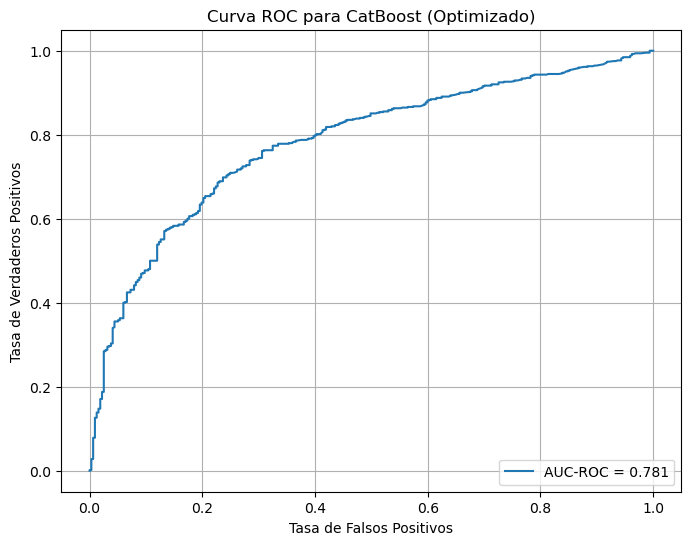

In [74]:
# Aplicamos los mejores parámetros encontrados en Grid Search al modelo CatBoost
optimized_catboost_model = CatBoostClassifier(
    random_state=42,
    eval_metric='AUC',  # Métrica principal AUC
    iterations=grid_search_catboost.best_params_['iterations'],
    learning_rate=grid_search_catboost.best_params_['learning_rate'],
    depth=grid_search_catboost.best_params_['depth'],
    subsample=grid_search_catboost.best_params_['subsample'],
    colsample_bylevel=grid_search_catboost.best_params_['colsample_bylevel'],
    verbose=0  # No muestra las iteraciones durante el entrenamiento
)

# Entrenamos el modelo con los datos optimizados
optimized_catboost_model.fit(X_train, y_train)

# Realizamos predicciones en el conjunto de prueba
y_pred_optimized_catboost = optimized_catboost_model.predict(X_test)
y_prob_optimized_catboost = optimized_catboost_model.predict_proba(X_test)[:, 1]  # Probabilidades de la clase positiva

# Evaluamos el rendimiento del modelo optimizado
print("Matriz de Confusión:")
print(confusion_matrix(y_test, y_pred_optimized_catboost))

print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred_optimized_catboost))

# Métricas principales
auc_roc_optimized_catboost = roc_auc_score(y_test, y_prob_optimized_catboost)
accuracy_optimized_catboost = accuracy_score(y_test, y_pred_optimized_catboost)

print(f"AUC-ROC del modelo optimizado: {auc_roc_optimized_catboost:.3f}")
print(f"Exactitud del modelo optimizado: {accuracy_optimized_catboost:.3f}")

# Graficamos la Curva ROC
fpr_catboost, tpr_catboost, thresholds_catboost = roc_curve(y_test, y_prob_optimized_catboost)
plt.figure(figsize=(8, 6))
plt.plot(fpr_catboost, tpr_catboost, label=f"AUC-ROC = {auc_roc_optimized_catboost:.3f}")
plt.xlabel("Tasa de Falsos Positivos")
plt.ylabel("Tasa de Verdaderos Positivos")
plt.title("Curva ROC para CatBoost (Optimizado)")
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [75]:
# Definimos el modelo CatBoost optimizado
catboost_model = CatBoostClassifier(
    random_state=42,
    eval_metric='AUC',
    colsample_bylevel=0.8,  # Porcentaje de características seleccionadas en cada nivel del árbol
    iterations=200,  # Número de iteraciones
    subsample=0.6,  # Porcentaje de datos muestreados para construir cada árbol
    learning_rate=0.05,  # Tasa de aprendizaje
    depth=4,  # Profundidad de los árboles
    verbose=0  # Supresión de salidas innecesarias durante validación
)

# Configuración del K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Definimos las métricas personalizadas
scoring = {
    'precision': make_scorer(precision_score, average='weighted'),
    'recall': make_scorer(recall_score, average='weighted'),
    'f1': make_scorer(f1_score, average='weighted'),
    'roc_auc': make_scorer(roc_auc_score, response_method='predict_proba')  # Usamos response_method para evitar advertencias
}

# Realizamos la validación cruzada con múltiples métricas
cv_results = cross_validate(
    catboost_model,
    X_train,
    y_train,
    cv=kf,
    scoring=scoring,
    return_train_score=True
)

# Mostramos los resultados promedio de cada métrica
print("Precisión promedio:", round(np.mean(cv_results['test_precision']), 3))
print("Recall promedio:", round(np.mean(cv_results['test_recall']), 3))
print("F1-Score promedio:", round(np.mean(cv_results['test_f1']), 3))
print("AUC-ROC promedio:", round(np.mean(cv_results['test_roc_auc']), 3))

Precisión promedio: 0.735
Recall promedio: 0.742
F1-Score promedio: 0.737
AUC-ROC promedio: 0.797


## Justificación y conclusiones de creación de modelos predictivos

**- Justificación:**

**Métricas seleccionadas:**
- Recall: Prioritaria para minimizar falsos negativos, esencial en problemas críticos como fraudes o diagnósticos médicos.
- AUC-ROC: Evalúa la capacidad del modelo para distinguir entre clases en distintos umbrales, proporcionando una visión global del rendimiento
- Precision y F1-Score: Complementan el Recall al medir la calidad de las predicciones positivas y equilibrar precisión y sensibilidad en datos desbalanceados.

**Modelos seleccionados:**
- Random Forest: Modelo versátil que maneja datos desbalanceados y evalúa la importancia de variables.
- XGBoost: Flexible y eficiente, optimiza métricas y maneja datos desbalanceados.
- CatBoost: Ideal para variables categóricas, evita preprocesamientos complejos y ofrece alto rendimiento.

<br>

**- Conclusiones:**
Se entrenaron modelos base y se optimizaron hiperparámetros para cada caso.  
Con un Recall elevado y el mejor AUC-ROC, se seleccionará Random Forest por ser el modelo más prometedor para la tarea de retención de clientes.